<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datasets
### FairFace
- Paper: https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf
- GitHub: https://github.com/joojs/fairface?tab=readme-ov-file

### UTKface
- Github: https://susanqq.github.io/UTKFace/

# 1. Loading and preprocessing data FairFace

## Loading

### Loading images

In [1]:
# Step 1: Install PyDrive
!pip install PyDrive

# Step 2: Import the required libraries
import os
import zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Step 3: Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 4: Specify the file ID from the link
file_id = '1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86'

# Step 5: Download the .zip file
downloaded = drive.CreateFile({'id': file_id})
zip_filename = 'downloaded_file.zip'  # Name of the downloaded zip file
downloaded.GetContentFile(zip_filename)

print(f"{zip_filename} downloaded successfully!")

# Step 6: Create the extracted directory if it doesn't exist
extract_dir = '/content/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Step 7: Extract the .zip file into the /content/extracted directory
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File extracted to {extract_dir}")

downloaded_file.zip downloaded successfully!
File extracted to /content/extracted


### Loading labels

In [2]:
# Step 1: Import the necessary libraries if not already imported
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Step 2: Authenticate and create the PyDrive client (if not already done)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 3: Function to download CSV file from Google Drive
def download_csv(file_id, destination):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(destination)
    print(f"Downloaded file saved as {destination}")

# Step 4: File IDs and destinations for Train and Validation labels
train_file_id = '1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH'  # Train labels file ID
val_file_id = '1wOdja-ezstMEp81tX1a-EYkFebev4h7D'    # Validation labels file ID

train_labels_path = '/content/train_labels.csv'
val_labels_path = '/content/val_labels.csv'

# Step 5: Download Train and Validation label CSV files
download_csv(train_file_id, train_labels_path)
download_csv(val_file_id, val_labels_path)

df_fairface_train = pd.read_csv(train_labels_path)
df_fairface_val = pd.read_csv(val_labels_path)

Downloaded file saved as /content/train_labels.csv
Downloaded file saved as /content/val_labels.csv


## Data preprocessing
- Currently uses train and validations set defined from the original paper -> no need to use data_split later

In [3]:
from pathlib import Path
from tqdm.notebook import tqdm  # For the progress bar (if not already installed, run: !pip install tqdm)

tqdm.pandas()

train_df = df_fairface_train.copy()
val_df = df_fairface_val.copy()

# Not sure what service_test is
train_df.drop(columns=['service_test'],inplace=True)
val_df.drop(columns=['service_test'],inplace=True)

# Define the base image directory
base_img = Path('/content/extracted')

# Update labels in both train_df and val_df
train_df['age'] = train_df['age'].replace('more than 70', '70+')
val_df['age'] = val_df['age'].replace('more than 70', '70+')

# Update the 'file' column for train and val dataframes
train_df['file'] = train_df['file'].progress_map(lambda x: base_img / x)
val_df['file'] = val_df['file'].progress_map(lambda x: base_img / x)

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [4]:
###### Mapping gender
gender_map = {'Male': 0, 'Female': 1}

train_df['gender_code'] = train_df['gender'].progress_map(lambda x:gender_map[x])
val_df['gender_code'] = val_df['gender'].progress_map(lambda x:gender_map[x])

###### Mapping age
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Setting the desired order
train_df['age'] = train_df['age'].astype('category')
train_df['age'] = train_df['age'].cat.set_categories(age_order, ordered=True)

# Encoding the age groups
train_df['age_code'] = train_df['age'].cat.codes

# Creating the age map
age_map = dict(zip(train_df['age'].cat.categories, range(len(train_df['age'].cat.categories))))
val_df['age_code'] = val_df['age'].progress_map(lambda x: age_map[x])

###### Mapping race
train_df['race'] = train_df['race'].astype('category')
train_df['race_code'] = train_df['race'].cat.codes

race_map = dict(zip(train_df['race'].cat.categories,range(len(train_df['race'].cat.categories))))
val_df['race_code'] = val_df['race'].progress_map(lambda x:race_map[x])

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [5]:
# New desired mapping: White, Black, Asian, Indian, and Others
# Create a function to map the current race categories to the target categories
def map_race_to_target(race):
    if race in ['East Asian', 'Southeast Asian']:
        return 'Asian'
    elif race in ['Latino_Hispanic', 'Middle Eastern']:
        return 'Others'
    else:
        return race  # Retain 'White', 'Black', and 'Indian' as is

# Define the desired category order
desired_order = ['White', 'Black', 'Asian', 'Indian', 'Others']

# Apply the mapping function to map the races to the target categories
train_df['race'] = train_df['race'].map(map_race_to_target)
val_df['race'] = val_df['race'].map(map_race_to_target)

# Convert to categorical type and set the desired category order
train_df['race'] = train_df['race'].astype('category')
train_df['race'] = train_df['race'].cat.set_categories(desired_order, ordered=True)

val_df['race'] = val_df['race'].astype('category')
val_df['race'] = val_df['race'].cat.set_categories(desired_order, ordered=True)

# Create 'race_code' using the ordered categories
train_df['race_code'] = train_df['race'].cat.codes
val_df['race_code'] = val_df['race'].cat.codes

# Create the new race_map based on the new categories
race_map_fair = dict(zip(range(len(desired_order)), desired_order))

# Display the resulting mappings
print("New Race Mapping:", race_map_fair)

New Race Mapping: {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}


In [6]:
# Assuming train_df and val_df are your dataframes
df_fairface_raw = pd.concat([train_df, val_df], ignore_index=True)
print(len(df_fairface_raw))
df_fairface_raw.head()

97698


,file,age,gender,race,gender_code,age_code,race_code
0,/content/extracted/train/1.jpg,50-59,Male,Asian,0,6,2
1,/content/extracted/train/2.jpg,30-39,Female,Indian,1,4,3
2,/content/extracted/train/3.jpg,3-9,Female,Black,1,1,1
3,/content/extracted/train/4.jpg,20-29,Female,Indian,1,3,3
4,/content/extracted/train/5.jpg,20-29,Female,Indian,1,3,3


In [7]:
from PIL import Image
import numpy as np

# Lists to store the extracted data
images_fairface = []
ages_fairface = df_fairface_raw['age_code'].tolist()  # List of age codes
genders_fairface = df_fairface_raw['gender_code'].tolist()  # List of gender codes
ethnicities_fairface = df_fairface_raw['race_code'].tolist()  # List of race codes

In [8]:
df_fairface_eda = df_fairface_raw[['age','gender','race']]
df_fairface_code = df_fairface_raw[['file','age_code','gender_code','race_code']]

### Data test

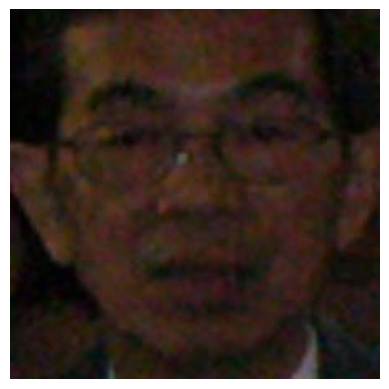

Shape: (224, 224, 3)


In [9]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/train/1.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")

# 2. Loading and preprocessing data UTKface

## Download data

In [10]:
!pip install PyDrive

In [11]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import tarfile

# Authenticate PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Folder ID from the shared Google Drive folder
folder_id = '1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G'
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Loop through the files and download each .tar.gz file
for file in file_list:
    if file['title'].endswith('.tar.gz'):
        print(f'Downloading {file["title"]}')
        file.GetContentFile(file['title'])

        # Extract the .tar.gz file
        tar = tarfile.open(file['title'])
        tar.extractall('/content/extracted')  # Extract all files to /content/extracted directory
        tar.close()

        print(f'Extracted {file["title"]}')

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz


## Data Preprocessing

### Data test

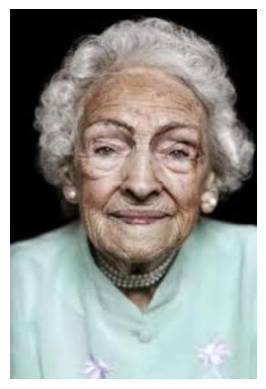

Shape: (551, 368, 3)


In [12]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/part3/100_1_0_20170119212053665.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")


### Delete non-images

In [13]:
import os

def delete_non_image_files(directories, allowed_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
    for directory in directories:
        for filename in os.listdir(directory):
            if not filename.lower().endswith(allowed_extensions):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete non-image files
delete_non_image_files(directories)

Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg
Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg
Deleted: /content/extracted/part3/.DS_Store


### Delete invalid mesasges

In [14]:
import os
import re

def delete_invalid_images(directories):
    # Regular expression pattern to match the desired format
    pattern = re.compile(r'^\d+_\d+_\d+_\d+\.\w+$')

    for directory in directories:
        for filename in os.listdir(directory):
            # Check if the filename matches the desired pattern
            if not pattern.match(filename):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete invalid images
delete_invalid_images(directories)

Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg


### Creating lists for training

In [15]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Initialize lists to store images and labels
images = []
ages_utkface = []
genders_utkface = []
ethnicities_utkface = []
files_utkface = []  # New list to store file paths

# Process each directory
for directory in directories:
    print(f"Processing from: {directory}")
    files = os.listdir(directory)

    for file in files:
        file_path = os.path.join(directory, file)  # Create the full file path

        if image is not None:  # Check if the image was loaded successfully
            # Parse filename to extract labels
            split_var = file.split('_')
            ages_utkface.append(int(split_var[0]))
            genders_utkface.append(int(split_var[1]))
            ethnicities_utkface.append(int(split_var[2]))
            files_utkface.append(file_path)  # Store the file path in the list
        else:
            print(f"Failed to load image: {file_path}")

# Create a dataframe from the lists
df_utkface = pd.DataFrame({
    'age': ages_utkface,
    'gender': genders_utkface,
    'ethnicity': ethnicities_utkface,
    'file': files_utkface  # Add the file paths as a column
})

Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


In [16]:
# Create a DataFrame from the lists
df_utkface_raw = pd.DataFrame({
    'file': files_utkface,
    'age_raw': ages_utkface,
    'gender_code': genders_utkface,
    'race_code': ethnicities_utkface
})

## Mapping

In [17]:
### Mapping age
# Define the age mapping function
def map_age(age):
    if age <= 2:
        return '0-2'
    elif 3 <= age <= 9:
        return '3-9'
    elif 10 <= age <= 19:
        return '10-19'
    elif 20 <= age <= 29:
        return '20-29'
    elif 30 <= age <= 39:
        return '30-39'
    elif 40 <= age <= 49:
        return '40-49'
    elif 50 <= age <= 59:
        return '50-59'
    elif 60 <= age <= 69:
        return '60-69'
    else:
        return '70+'

# Map the 'age_raw' column to the 'age' column
df_utkface_raw['age'] = df_utkface_raw['age_raw'].apply(map_age)

# Setting the desired order for 'age'
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_utkface_raw['age'] = df_utkface_raw['age'].astype('category')
df_utkface_raw['age'] = df_utkface_raw['age'].cat.set_categories(age_order, ordered=True)

# Encoding the age groups
df_utkface_raw['age_code'] = df_utkface_raw['age'].cat.codes

In [18]:
# Mapping gender
# Define gender mapping
gender_map = {0: 'Male', 1: 'Female'}

# Map 'gender_code' to the 'gender' column
df_utkface_raw['gender'] = df_utkface_raw['gender_code'].map(gender_map)

# Mapping race
# Define race mapping based on the specified order
race_map_utk = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Map 'race_code' to the 'race' column
df_utkface_raw['race'] = df_utkface_raw['race_code'].map(race_map_utk)

In [19]:
df_utkface_code = df_utkface_raw[['file','age_code','gender_code','race_code']]
df_utkface_eda = df_utkface_raw[['age','gender','race']]

# 3. EDA

## EDA Fairface

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


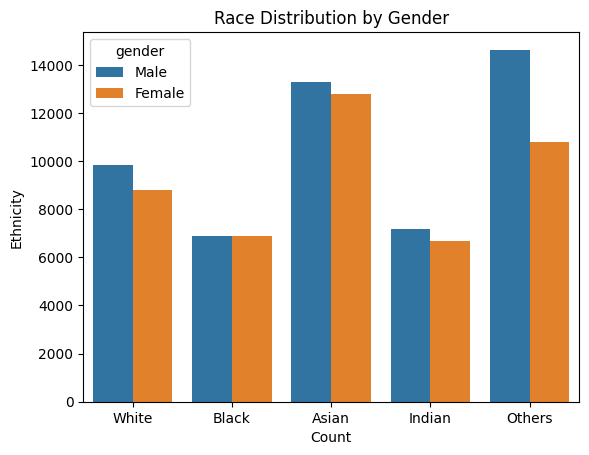

In [20]:
# Get libraries for loading data and plotting subgroups

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plotting race/ethnicity with ethnicity on the y-axis and count on the x-axis
sns.countplot(data=df_fairface_eda, x='race', hue='gender')

# Adding plot labels
plt.title('Race Distribution by Gender')
plt.xlabel("Count")
plt.ylabel("Ethnicity")

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='gender', ylabel='count'>

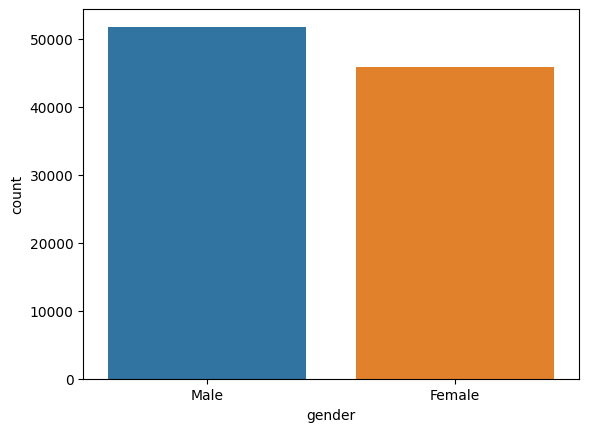

In [21]:
# Then gender distribution is almost perfectly 50/50
sns.countplot(data=df_fairface_eda, x ='gender', hue ='gender')

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


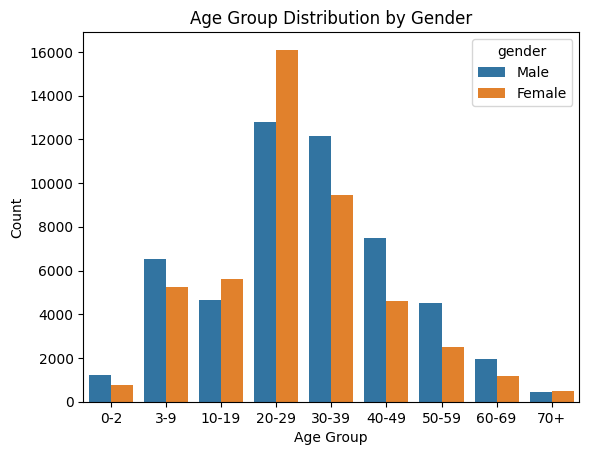

In [22]:
# Ensure the age column in df_fairface_eda has the correct category order using .loc to avoid the warning
df_fairface_eda.loc[:, 'age'] = pd.Categorical(df_fairface_eda['age'], categories=age_order, ordered=True)

# Now you can plot the correctly ordered age group distribution
sns.countplot(data=df_fairface_eda, x='age', hue='gender', order=age_order)

# Adding plot labels
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

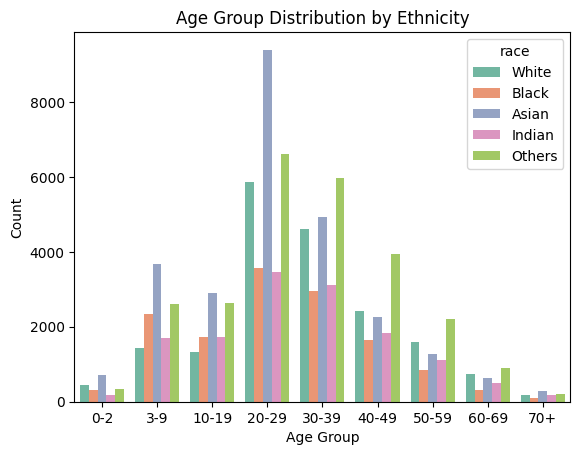

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Now you can plot the correctly ordered age group distribution by race (ethnicity)
sns.countplot(data=df_fairface_eda, x='age', hue='race', palette='Set2', order=age_order)

# Adding plot labels
plt.title('Age Group Distribution by Ethnicity')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## EDA UTKface

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


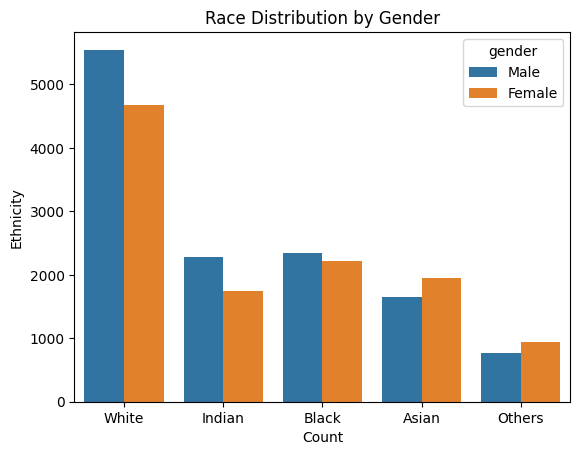

In [24]:
# Get libraries for loading data and plotting subgroups

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plotting race/ethnicity with ethnicity on the y-axis and count on the x-axis
sns.countplot(data=df_utkface_eda, x='race', hue='gender')

# Adding plot labels
plt.title('Race Distribution by Gender')
plt.xlabel("Count")
plt.ylabel("Ethnicity")

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='gender', ylabel='count'>

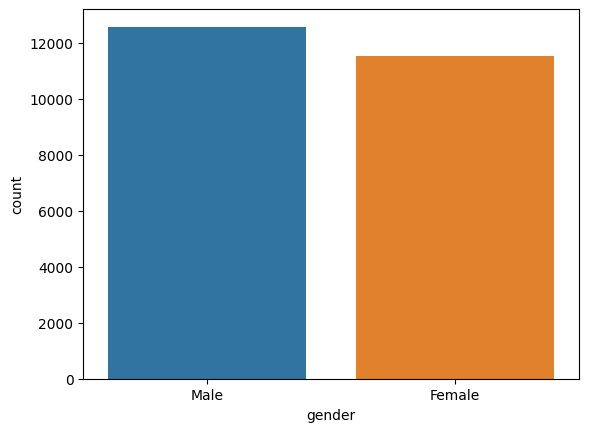

In [25]:
# Then gender distribution is almost perfectly 50/50
sns.countplot(data=df_utkface_eda, x ='gender', hue ='gender')

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


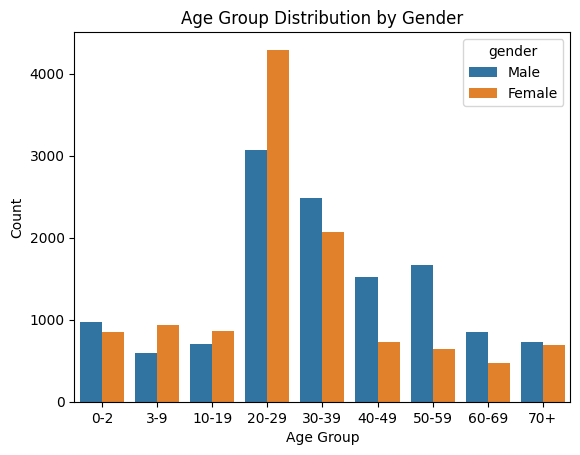

In [26]:
# Ensure the age column in df_utkface_eda has the correct category order using .loc to avoid the warning
df_utkface_eda.loc[:, 'age'] = pd.Categorical(df_utkface_eda['age'], categories=age_order, ordered=True)

# Now you can plot the correctly ordered age group distribution
sns.countplot(data=df_utkface_eda, x='age', hue='gender', order=age_order)

# Adding plot labels
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

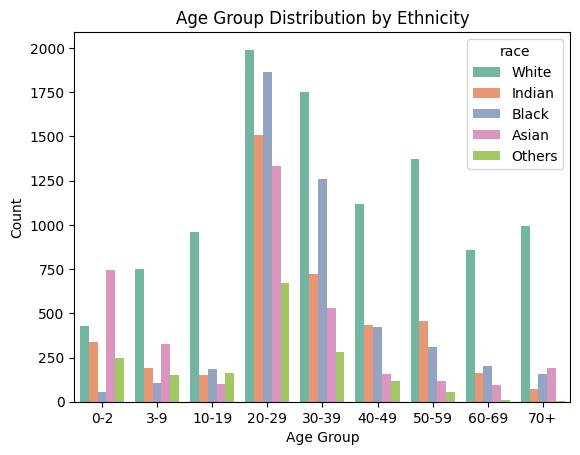

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Now you can plot the correctly ordered age group distribution by race (ethnicity)
sns.countplot(data=df_utkface_eda, x='age', hue='race', palette='Set2')

# Adding plot labels
plt.title('Age Group Distribution by Ethnicity')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

# 4. Normalizing age group distribution
## Methods
1. Age groups 0-2 and 3-9 are combined into 0-9
2. Age groups from 50-59, 60-69 and 70+ are combined into 50+
3. Add data from UTKface to: 0-9, 10-19, 40-49, and 50+

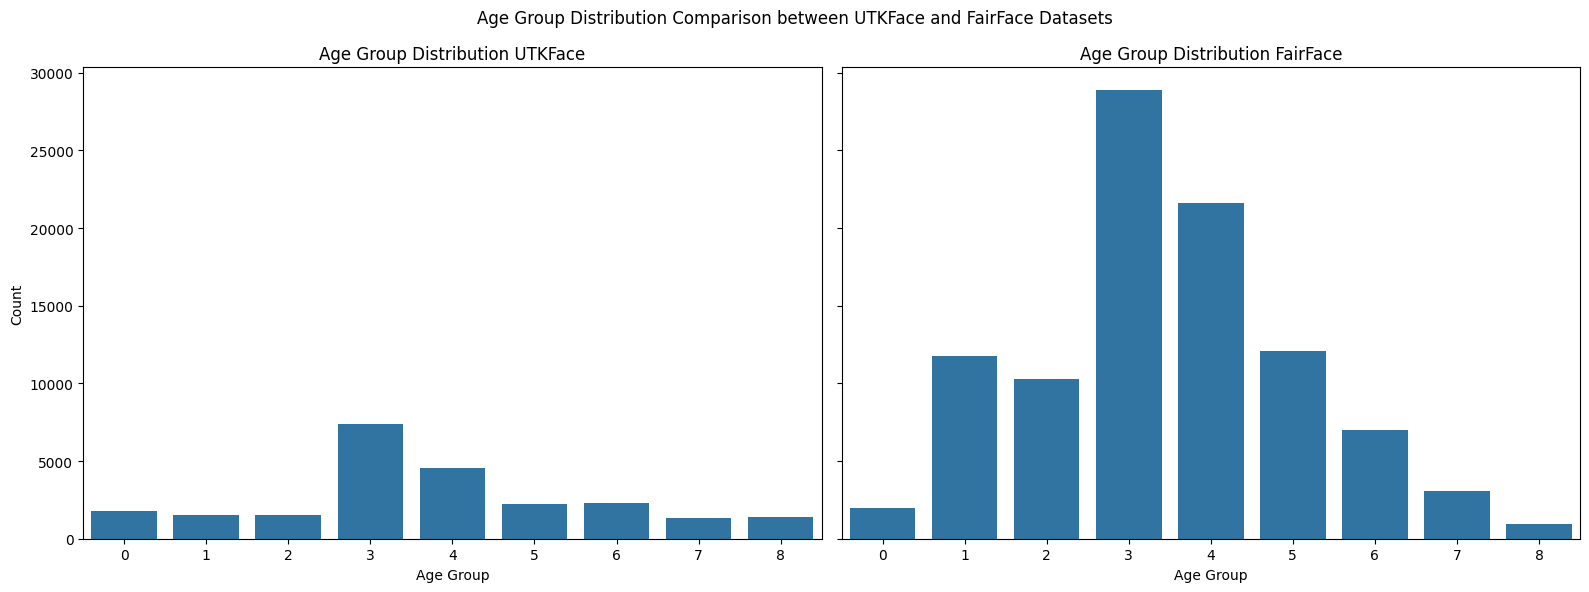

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the first distribution for the UTKFace dataset
sns.countplot(data=df_utkface_code, x='age_code', ax=axes[0])
axes[0].set_title('Age Group Distribution UTKFace')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(len(age_map)))
axes[0].set_xticklabels(age_map.values())

# Plot the second distribution for the FairFace dataset
sns.countplot(data=df_fairface_code, x='age_code', ax=axes[1])
axes[1].set_title('Age Group Distribution FairFace')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(age_map)))
axes[1].set_xticklabels(age_map.values())

# Adjust the layout and show the plots
plt.suptitle('Age Group Distribution Comparison between UTKFace and FairFace Datasets')
plt.tight_layout()
plt.show()

In [29]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 and 1 into group 0
    elif age_code in [6, 7, 8]:
        return 6  # Merge age groups 6, 7, and 8 into group 6
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_fairface = df_fairface_code.copy()

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5   # '50+'
}

# Apply the sequential mapping using .loc
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50+'      # Group 5 (previously group 6)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_fairface.loc[:, 'age'] = df_fairface['age_code'].map(age_group_mapping)


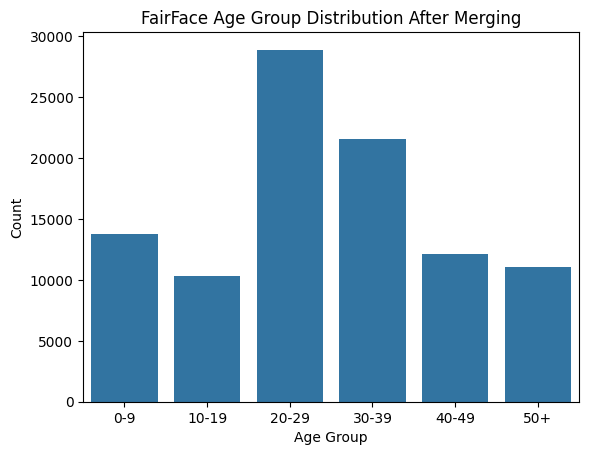

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_fairface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_fairface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('FairFace Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

In [31]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 and 1 into group 0
    elif age_code in [6, 7, 8]:
        return 6  # Merge age groups 6, 7, and 8 into group 6
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_utkface = df_utkface_code.copy()

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5   # '50+'
}

# Apply the sequential mapping using .loc
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50+'      # Group 5 (previously group 6)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_utkface.loc[:, 'age'] = df_utkface['age_code'].map(age_group_mapping)

<ipython-input-31-8ad469bbc8ec>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6 0 0 ... 3 6 4]' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(merge_age_groups)


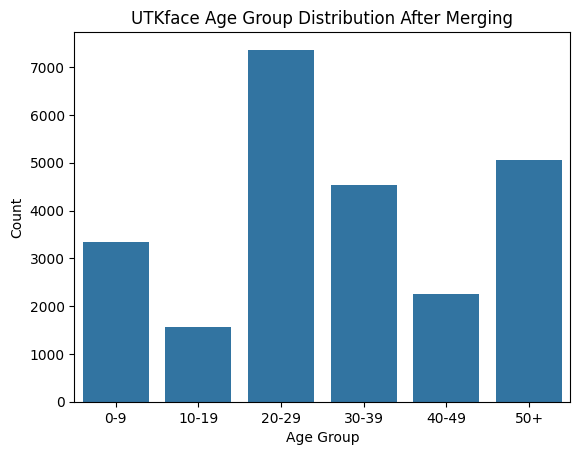

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_utkface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_utkface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('UTKface Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## Concatenating age groups 0, 1, 4, and 5

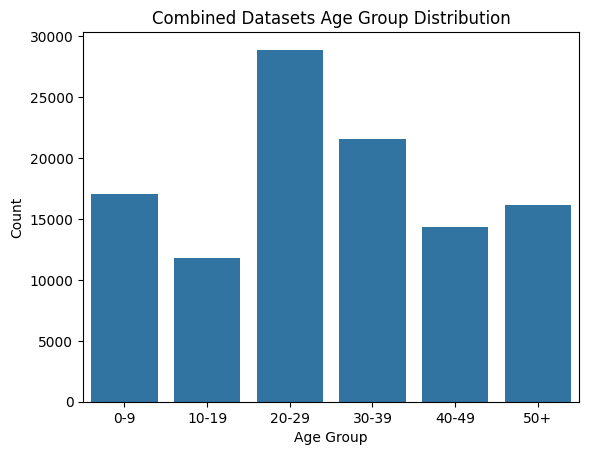

In [33]:
import pandas as pd

# Step 1: Filter `df_utkface` to include only the specified age groups
filtered_utkface = df_utkface[df_utkface['age_code'].isin([0, 1, 4, 5])]

# Step 2: Concatenate the filtered `df_utkface` with `df_fairface`
df = pd.concat([df_fairface, filtered_utkface], ignore_index=True)

# Define the correct order of the age groups based on the mapping
age_order = sorted(df['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('Combined Datasets Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

# 5. Loading and preprocessing images and ages

In [34]:
import numpy as np
import pandas as pd
from PIL import Image

# Select only 100 random images from the dataframe
sample_df = df.sample(n=100, random_state=42)  # Set random_state for reproducibility

# Initialize lists to store images and their corresponding age groups
images = []
ages = []

# Load images and corresponding age groups from the 'file' and 'age_code' columns of the sampled dataframe
for _, row in sample_df.iterrows():  # Iterate over each row in the sampled dataframe
    img_path = row['file']           # Extract the file path
    age_code = row['age_code']       # Extract the age code

    try:
        # Open the image
        img = Image.open(img_path)

        # Resize the image to the target size (224, 224)
        img = img.resize((224, 224))

        # Convert the resized image to a numpy array
        img = np.array(img)  # Convert to a numpy array
        images.append(img)   # Append the image to the list
        ages.append(age_code)  # Append the age code to the 'ages' list
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Convert images and ages lists to numpy arrays
images = np.array(images)
ages = np.array(ages)

# 6. Baseline MobileNet v3

In [35]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model setup

In [36]:
from keras.applications.mobilenet_v3 import preprocess_input  # Update the import for MobileNet
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models  # Import the required modules

# Preprocess your images using the MobileNet preprocessing
images_preprocessed = preprocess_input(images)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images_preprocessed, ages, test_size=0.2, random_state=42, stratify=ages
)

print(f"Training set: {X_train.shape}, Training labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Validation labels: {y_val.shape}")

# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Number of classes for target variable
num_classes = len(age_group_mapping)


print("Conv base, training, and validation sets have been created...")

Training set: (80, 224, 224, 3), Training labels: (80,)
Validation set: (20, 224, 224, 3), Validation labels: (20,)
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Conv base, training, and validation sets have been created...


In [37]:
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         492,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,621,254 (13.81 MB)

 Trainable params: 624,902 (2.38 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [38]:
# Set custom learning rate
initial_learning_rate = 1e-3  # Adjust as needed
first_decay_steps = 1000

lr_decayed_fn = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.0,
    name="SGDRDecay",
)

optimizer = keras.optimizers.AdamW(learning_rate=lr_decayed_fn)


model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

file_path = '/content/drive/MyDrive/DL for VR/Project/Models/'

model_name = 'best_mobilenet_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

## Model train

In [41]:
mobilenet_history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1167 - loss: 2.3039
Epoch 1: val_accuracy improved from -inf to 0.15000, saving model to /content/drive/MyDrive/DL for VR/Project/Models/best_mobilenet_model_baseline.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.1281 - loss: 2.2906 - val_accuracy: 0.1500 - val_loss: 1.9398
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3531 - loss: 1.7402
Epoch 2: val_accuracy improved from 0.15000 to 0.20000, saving model to /content/drive/MyDrive/DL for VR/Project/Models/best_mobilenet_model_baseline.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.3617 - loss: 1.7357 - val_accuracy: 0.2000 - val_loss: 1.8700
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5177 - loss: 1.5109
Epoch 3: val_accuracy improved from 0.20000 to 0.30000, saving model to /content/drive/MyDrive/DL for VR/Project/Models/best_mobilenet_model_baseline.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5070 - loss: 1.

## Model evaluation

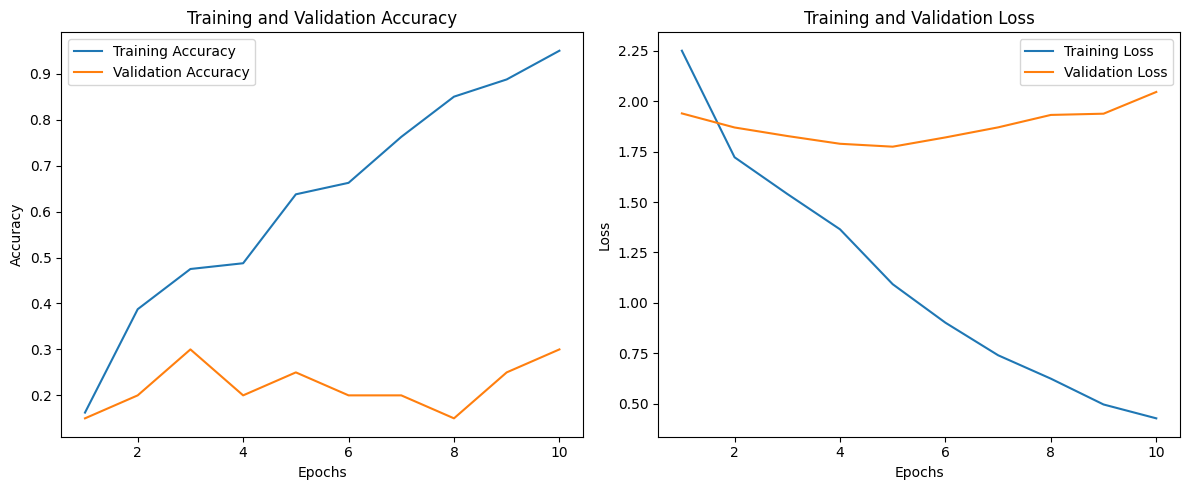

In [42]:
import matplotlib.pyplot as plt

# Get the accuracy and loss data from the history object
accuracy = mobilenet_history.history['accuracy']
val_accuracy = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [48]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with actual model prediction logic, e.g., from a Keras or Scikit-learn model
# Example (for Keras): Assuming you have one-hot encoded predictions
y_pred = model.predict(X_val)  # x_test is your test data
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to sparse integer predictions

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


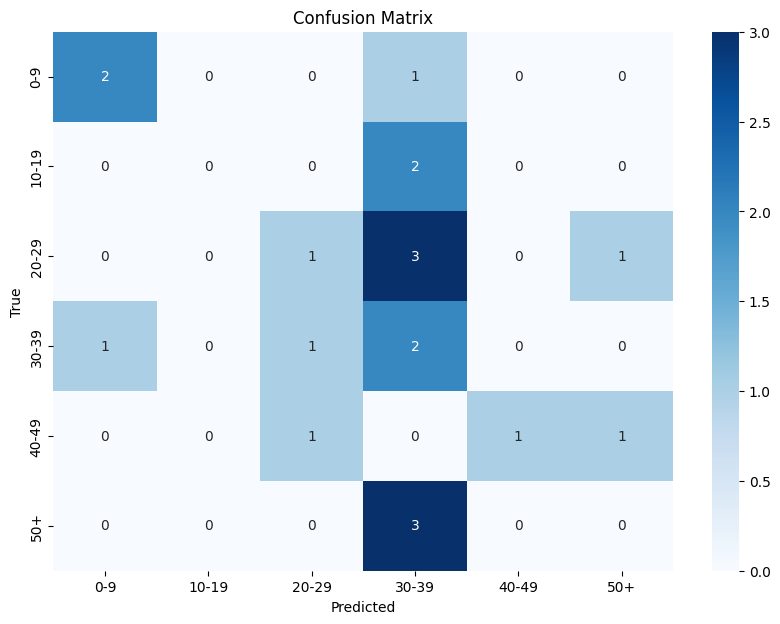

In [49]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=age_group_mapping.values(), yticklabels=age_group_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()